# Plotting UKESM1 files directly

### Import packages and define functions for calculations

In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray
import numpy
import cartopy
import matplotlib
%matplotlib inline

# Add a couple of deep down individual functions.
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import AutoMinorLocator

# used to create area averages over AR6 regions.
import regionmask

# hide some warning messages
import warnings
warnings.filterwarnings("ignore")


## Computing and plotting the global mean surface temperature changes 

In [2]:
# Download and load the historical/ssp126 UKESM1 output
# then combine then into one single file which covers the time period from 1850-2100

filename_hist_1='~/geog0121_shared_space/cmip6_UKESM1_data/historical/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
filename_hist_2='~/geog0121_shared_space/cmip6_UKESM1_data/historical/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc'

filename_ssp126_1='~/geog0121_shared_space/cmip6_UKESM1_data/ssp126/tas_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_201501-204912.nc'
filename_ssp126_2='~/geog0121_shared_space/cmip6_UKESM1_data/ssp126/tas_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_205001-210012.nc'

filename_ssp585_1='~/geog0121_shared_space/cmip6_UKESM1_data/ssp585/tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc'
filename_ssp585_2='~/geog0121_shared_space/cmip6_UKESM1_data/ssp585/tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc'

In [3]:
historical=xarray.open_mfdataset(paths=[filename_hist_1,filename_hist_2],combine='by_coords')
tas_hist=historical.tas #just select the surface air temperatures

ssp126=xarray.open_mfdataset(paths=[filename_ssp126_1,filename_ssp126_2],combine='by_coords')
tas_126=ssp126.tas #just select the surface air temperatures

ssp585=xarray.open_mfdataset(paths=[filename_ssp585_1,filename_ssp585_2],combine='by_coords')
tas_585=ssp585.tas #just select the surface air temperatures

In [4]:
#Set as anomalies from 1981-2010
baseline=tas_hist.sel(time=slice('1981-01-01', '2010-12-30'))
climatology = baseline.groupby("time.month").mean("time")
tasA_hist = tas_hist.groupby("time.month") - climatology
tasA_126 = tas_126.groupby("time.month") - climatology
tasA_585 = tas_585.groupby("time.month") - climatology

In [5]:
# create some area-weights to average the fields with
weights=tas_hist[0,:,:] #using tas to copy over metadata  #select the 1st timestep
weights = numpy.cos(numpy.deg2rad(historical.lat))
weights.name = "weights"
    
#Make some field with the weighting applied
tasA_wgtd_hist=tasA_hist.weighted(weights)
tasA_wgtd_126=tasA_126.weighted(weights)
tasA_wgtd_585=tasA_585.weighted(weights)

In [6]:
#Create the global mean temperatures...
gmt_hist = tasA_wgtd_hist.mean(dim=('lat', 'lon'))
gmt_126 = tasA_wgtd_126.mean(dim=('lat', 'lon'))
gmt_585 = tasA_wgtd_585.mean(dim=('lat', 'lon'))

In [7]:
#Create some 5 year smoothed versions (60 months)
gmt_hist=gmt_hist.chunk(1980) #re-chunking array to avoid error on next line
gmt_hist_smoothed=gmt_hist.rolling(time=60,center=True).mean(dim=('time'))
gmt_126=gmt_126.chunk(1032) #re-chunking time series into single long block to avoid error on next line
gmt_126_smoothed=gmt_126.rolling(time=60,center=True).mean(dim=('time'))
gmt_585=gmt_585.chunk(1032) #re-chunking all months into single long block to avoid error on next line
gmt_585_smoothed=gmt_585.rolling(time=60,center=True).mean(dim=('time'))

Text(0.5, 1.0, 'GMST')

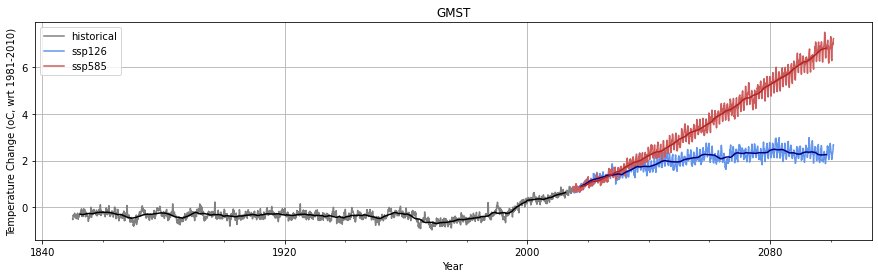

In [8]:
# Create a line plot of monthly global mean surface temperature anomalies
fig, ax = matplotlib.pyplot.subplots(figsize=(15,4))
gmt_hist.plot(ax=ax, label='historical',color='grey')
gmt_126.plot(ax=ax, label='ssp126',color='cornflowerblue')
gmt_585.plot(ax=ax, label='ssp585',color='indianred')
gmt_126_smoothed.plot(ax=ax,color='navy')
gmt_hist_smoothed.plot(ax=ax,color='black')
gmt_585_smoothed.plot(ax=ax,color='firebrick')
ax.grid()
ax.xaxis.set_minor_locator(AutoMinorLocator())   
ax.legend(loc='best') 
ax.set(xlabel='Year',ylabel='Temperature Change (oC, wrt 1981-2010)')
matplotlib.pyplot.title('GMST')

## AR6 Regions
For the upcoming IPCC report, there are a series of pre-defined regions. You may want to use them in your own research

<regionmask.Regions>
Name:     AR6 reference regions
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)

Regions:
  0  GIC       Greenland/Iceland
  1  NWN       N.W.North-America
  2  NEN       N.E.North-America
  3  WNA         W.North-America
  4  CNA         C.North-America
..   ...                     ...
 53  ARS             Arabian-Sea
 54  BOB           Bay-of-Bengal
 55  EIO  Equatorial.Indic-Ocean
 56  SIO           S.Indic-Ocean
 57  SOO          Southern-Ocean

[58 regions]

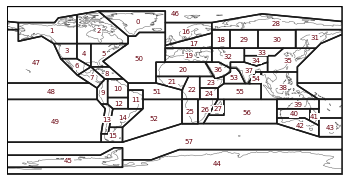

In [9]:
# Show what regions are available...
regionmask.defined_regions.ar6.all.plot(text_kws=dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w")))
regionmask.defined_regions.ar6.all

In [10]:
# First of all, we will take the annual average of all the temperature data loaded above.
ann_tasA_hist = tasA_hist.groupby("time.year").mean()
ann_tasA_126 = tasA_126.groupby("time.year").mean()
ann_tasA_585 = tasA_585.groupby("time.year").mean()

In [11]:
# Then we create a mask and apply it over Northern Europe (region number 16)
mask = regionmask.defined_regions.ar6.all.mask(ann_tasA_hist)
NEU_weights=weights.where(mask == 16 ,0) # The ,0 in the where commands sets the weight as 0 outside region 16.

In [12]:
# Now we take the weighted average over the regional to create a timeseries
NEU_hist=ann_tasA_hist.weighted(NEU_weights).mean(dim=('lat', 'lon'))
NEU_126=ann_tasA_126.weighted(NEU_weights).mean(dim=('lat', 'lon'))
NEU_585=ann_tasA_585.weighted(NEU_weights).mean(dim=('lat', 'lon'))

Text(0.5, 1.0, 'Northern Europe Annual Mean')

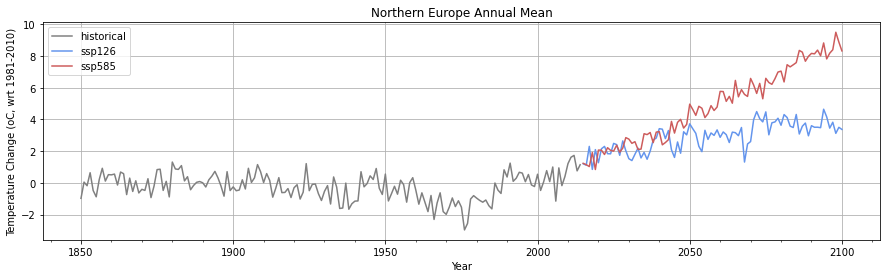

In [13]:
# Create a line plot of annual mean surface temperature anomalies over Northern Europe
fig, ax = matplotlib.pyplot.subplots(figsize=(15,4))
NEU_hist.plot(ax=ax, label='historical',color='grey')
NEU_126.plot(ax=ax, label='ssp126',color='cornflowerblue')
NEU_585.plot(ax=ax, label='ssp585',color='indianred')
ax.grid()
ax.xaxis.set_minor_locator(AutoMinorLocator())   
ax.legend(loc='best') 
ax.set(xlabel='Year',ylabel='Temperature Change (oC, wrt 1981-2010)')
matplotlib.pyplot.title('Northern Europe Annual Mean')

## Plot rainfall over an area

In [14]:
# Load in relevant data file
rainfall_filename='~/geog0121_shared_space/cmip6_UKESM1_data/historical/pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc' # pr historical run, year 1850-2014

In [15]:
rainfall_file=xarray.open_dataset(rainfall_filename)
# Create DJF rainfall average in mm/day
pr_data=rainfall_file.pr.sel(time=slice('1981-01-01','2010-12-30')) # select a time period and 
winter_average=pr_data.where(pr_data.time['time.season'] == 'DJF').mean(dim=('time')) #select just a particular season and create an average over it
winter_average=winter_average*86400 #convert units: 1 kg/m2/s = 86400 mm/day.

In [16]:
# Select just the USA (by adding together 3 regions)
mask = regionmask.defined_regions.ar6.all.mask(winter_average)
usa = mask.where(mask == 3,0)+mask.where(mask == 4,0)+mask.where(mask == 5,0) #combine the regions into a single mask
pr_usa = winter_average.where(usa)

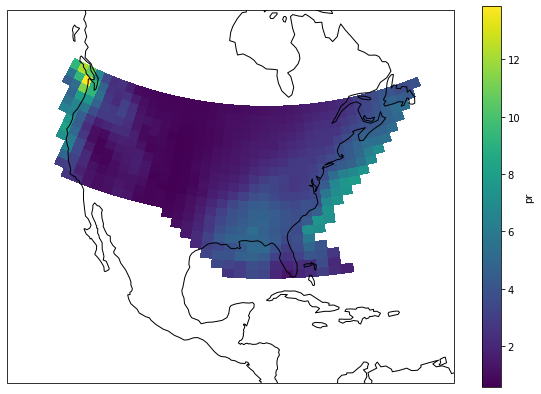

In [17]:
# choose a good projection for regional maps
matplotlib.pyplot.figure(figsize=(10,7))
proj=cartopy.crs.LambertConformal(central_longitude=-85)
ax = matplotlib.pyplot.subplot(111, projection=proj)
ax.set_extent([-120, -60, 10, 60], crs=cartopy.crs.PlateCarree())

# do the plot
pr_usa.plot.pcolormesh(ax=ax, transform=cartopy.crs.PlateCarree())
ax.coastlines()

# Winds
Visualising winds is a bit tricky as you need to consider direction as well as magnitude. So here we will create a vector diagram. 

In [18]:
va_file='~/geog0121_shared_space/cmip6_UKESM1_data/historical/va_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc'
ua_file='~/geog0121_shared_space/cmip6_UKESM1_data/historical/ua_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc'

In [19]:
d1=xarray.open_dataset(va_file)
va=d1.va
d2=xarray.open_dataset(ua_file)
ua=d2.ua
lat=d2.lat
lon=d2.lon-180 #change [0,360] to [-180,180]
plev=d2.plev #pressure in Pa, from surface to top

In [20]:
#Identify 2D latitudes and longitudes
lon2d, lat2d = numpy.meshgrid(lon, lat)

In [21]:
#time-averaged wind speed
va_ave=va.sel(time=slice('1981-01-01', '2010-12-30')).mean(dim=('time'))
ua_ave=ua.sel(time=slice('1981-01-01', '2010-12-30')).mean(dim=('time'))

In [22]:
# wind stress at chosen pressure level
#surface at 1000mb
va_1000mb=va_ave[0]
ua_1000mb=ua_ave[0]
#at 850mb
va_850mb=va_ave[2]
ua_850mb=ua_ave[2]
#at 500mb
va_500mb=va_ave[5]
ua_500mb=ua_ave[5]
#at 250mb
va_250mb=va_ave[8]
ua_250mb=ua_ave[8]


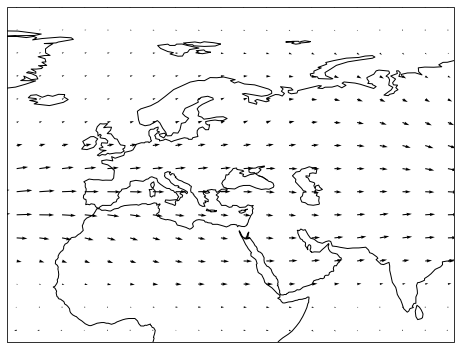

In [23]:
region=[-30, 90, 0, 90] #[lon_min,lon_max,lat_min,lat_max]
projection=cartopy.crs.PlateCarree()
transform=cartopy.crs.PlateCarree()
matplotlib.pyplot.figure(figsize=(8, 10))
ax = matplotlib.pyplot.axes(projection=projection)
ax.coastlines()
ax.quiver(lon2d, lat2d, ua_250mb.values, va_250mb.values, transform=transform,regrid_shape=30) 
#not including the .values leads to error about ravel 
ax.set_extent(region, cartopy.crs.PlateCarree())


# The Ocean Grid

Working with model output on the ocean grid, with its rotated pole, presents an additional challenge. You must use the advanced features of `cartopy`, which comes bundeled with both the `geog0121` and `geog0111` virtual environments on the JupyterHub, but may not available elsewhere.

## Sea surface temperature

In [24]:
variable_name='tos'
filename_a='~/geog0121_shared_space/cmip6_UKESM1_data/historical/tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
filename_b='~/geog0121_shared_space/cmip6_UKESM1_data/ssp370/tos_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc'

In [25]:
#Load in the data
expt_a_file=xarray.open_dataset(filename_a,decode_times=False)
expt_a=expt_a_file[variable_name]

expt_b_file=xarray.open_dataset(filename_b,decode_times=False)
expt_b=expt_b_file[variable_name]

#2D coordinates
latitude=expt_a_file['latitude']
longitude=expt_a_file['longitude']

In [26]:
# Now we take the time-averages
mn_a=numpy.average(expt_a,axis=0)
mn_b=numpy.average(expt_b,axis=0)

diff=mn_b-mn_a

Having now created the field to actually plot, let's get on doing so

In [27]:
#temperatures
cmap=matplotlib.pyplot.get_cmap('bwr') #define colormap

#define colormap's range and scale
clim=[-6,6]
bounds = numpy.linspace(clim[0], clim[1], 21)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

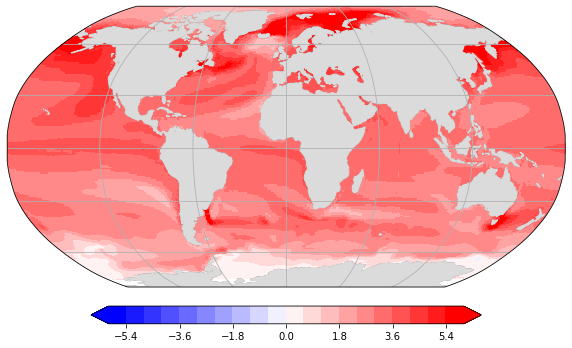

In [28]:
#Global map

projection = cartopy.crs.Robinson()
transform=cartopy.crs.PlateCarree()

matplotlib.pyplot.figure(figsize=(10,7))
ax = matplotlib.pyplot.axes(projection=projection)

ax.coastlines(resolution='110m', linewidth=0.5)
ax.gridlines()

fig=ax.pcolormesh(longitude,latitude,diff,transform=transform,cmap=cmap,norm=norm,shading="flat")
ax.add_feature(cartopy.feature.LAND, zorder=1,facecolor=cartopy.feature.COLORS['land_alt1'])
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
matplotlib.pyplot.colorbar(fig,cax=cax,extend='both',**kw)

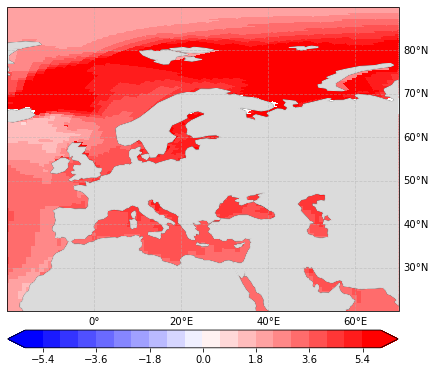

In [29]:
#Regional map
region=[-20,70,20,90] #[lon_min,lon_max,lat_min,lat_max]

projection = cartopy.crs.PlateCarree(central_longitude=0.0, globe=None)
transform=cartopy.crs.PlateCarree()

matplotlib.pyplot.figure(figsize=(10,7))
ax = matplotlib.pyplot.axes(projection=projection)

ax.coastlines()
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


fig=ax.pcolormesh(longitude,latitude,diff, transform=transform,cmap=cmap,norm=norm,shading="flat")
ax.add_feature(cartopy.feature.LAND, zorder=1,facecolor=cartopy.feature.COLORS['land_alt1'])
ax.set_extent(region, cartopy.crs.PlateCarree())

cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
matplotlib.pyplot.colorbar(fig,cax=cax,extend='both',**kw)

#matplotlib.pyplot.savefig(figname)

# Vertical structure
Now we will demonstrate how to create a zonal mean warming pattern in the atmosphere

In [30]:
#Load the files
ta_filename_370='~/geog0121_shared_space/cmip6_UKESM1_data/ssp370/ta_Amon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc'
ta_filename_hist='~/geog0121_shared_space/cmip6_UKESM1_data/historical/ta_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'

In [31]:
#This cell actually loads the 3D data
ta_hist=xarray.open_dataset(ta_filename_hist)
ta_370=xarray.open_dataset(ta_filename_370)

In [32]:
# Now we take the time-averages
znavg_ta_hist=ta_hist.ta.sel(time=slice('1850-01-01', '1900-12-30')).mean(dim=('time','lon'))
znavg_ta_370=ta_370.ta.sel(time=slice('2071-01-01', '2100-12-30')).mean(dim=('time','lon'))
# And compute the difference between them
zndiff=znavg_ta_370-znavg_ta_hist

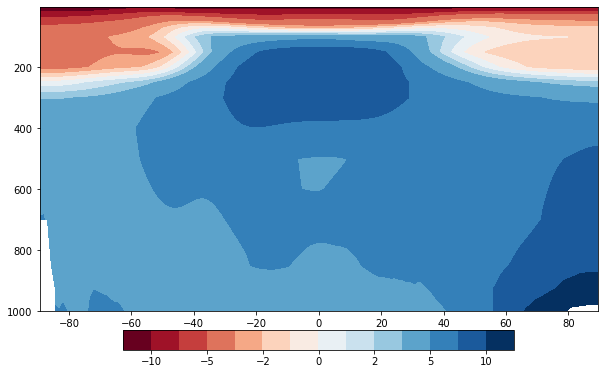

In [33]:
cmap=matplotlib.pyplot.get_cmap('RdBu') #define colormap
#define colormap's range and scale
bounds = [-15,-10,-7,-5,-3,-2,-1,0,1,2,3,5,7,10,15]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

matplotlib.pyplot.figure(figsize=(10,7))

ax = matplotlib.pyplot.axes()
fig=ax.contourf(zndiff.lat,zndiff.plev*0.01,zndiff,levels=bounds,cmap=cmap,norm=norm)
ax.invert_yaxis()

cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
matplotlib.pyplot.colorbar(fig,cax=cax,extend='both',**kw)

This plot shows that only the troposphere is warming - the stratosphere (upper atmosphere) is cooling. The higher you go into the troposphere the more it warms, especially over the Equator. The Arctic (on the right) is warming more than the rest of the globe. 

## Plot the AMOC 
Select the mean meridional mass overturning streamfunction in the north Atlantic Ocean under ssp585 scenario

In [34]:
# List the file names
msftyz_hist_1='~/geog0121_shared_space/cmip6_UKESM1_data/historical/msftyz_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
msftyz_hist_2='~/geog0121_shared_space/cmip6_UKESM1_data/historical/msftyz_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc'
msftyz_ssp585_1='~/geog0121_shared_space/cmip6_UKESM1_data/ssp585/msftyz_Omon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc'
msftyz_ssp585_2='~/geog0121_shared_space/cmip6_UKESM1_data/ssp585/msftyz_Omon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc'

In [35]:
# Open the relevant files from the historical and ssp585 simulations   
combined_dataset = xarray.open_mfdataset(paths=[msftyz_hist_1,msftyz_hist_2,msftyz_ssp585_1,msftyz_ssp585_2], autoclose=True)
# Select only the North Atlantic (from 0-90oN and basin=0)
streamfunction=combined_dataset.msftyz.sel(rlat=slice(0,90),basin=0) 

In [36]:
# Made the DataArray a bit more useful
streamfunction=1e-9*streamfunction   # convert units: 1 kg/s = 1*(10)^(-9) Sv
sf=streamfunction.groupby("time.year").mean()  # compute annual mean
sf #print out some information about the resulting DataArray - including the dimensions

<xarray.DataArray 'msftyz' (year: 251, lev: 75, rlat: 145)>
dask.array<stack, shape=(251, 75, 145), dtype=float32, chunksize=(1, 75, 145), chunktype=numpy.ndarray>
Coordinates:
    sector   |S17 dask.array<chunksize=(), meta=np.ndarray>
  * lev      (lev) float64 0.0 1.024 2.103 3.251 ... 5.393e+03 5.596e+03 5.8e+03
  * rlat     (rlat) float64 0.0 0.3333 0.6666 0.9999 ... 81.67 81.73 81.77 81.79
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100

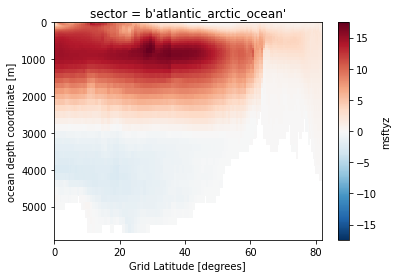

In [37]:
# plot a latitude-depth plot of the streamfunction during the 30 years centered on 2020
AMOC_pattern=sf.sel(year=slice(2006,2030)).mean(dim='year')
AMOC_pattern.plot(yincrease=False)

In [ ]:
#plot a time series of the maximum streamfunction at 30oN below 500m
AMOC_30N=sf.sel(rlat=slice(29,31),lev=slice(500,6000)).max(dim=('rlat','lev'))
AMOC_30N.plot()

# Machine specific options

This code above is intended to be run on UCL's JupyterHub facility. However it might happen that you need to run this notebook on a different machine. In the cells below, you will find the code to run on the cluster in UCL Geography and on an python installation on your own machine respectively.

In [ ]:
# TAS - FOR THE GEOGRAPHY CLUSTER
filename_hist_1='/data/CMIP/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Amon/tas/gn/v20190406/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
filename_hist_2='/data/CMIP/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Amon/tas/gn/v20190406/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc'

filename_ssp126_1='/data/CMIP/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r1i1p1f2/Amon/tas/gn/v20190503/tas_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_201501-204912.nc'
filename_ssp126_2='/data/CMIP/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r1i1p1f2/Amon/tas/gn/v20190503/tas_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_205001-210012.nc'

filename_ssp585_1='/data/CMIP/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Amon/tas/gn/v20190507/tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc'
filename_ssp585_2='/data/CMIP/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ss585/r1i1p1f2/Amon/tas/gn/v20190507/tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc'

In [ ]:
import os
import urllib
filename_hist_1='Data/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
if not os.path.isfile(filename_hist_1):
    print('Downloading %s' %(filename_hist_1))
    !mkdir Data
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/historical/Amon/tas/gn/v20190406/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc",filename_hist_1)    

filename_hist_2='Data/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc'
if not os.path.isfile(filename_hist_2):
    print('Downloading %s' %(filename_hist_2))
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/historical/Amon/tas/gn/v20190406/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc",filename_hist_2)    

filename_ssp126_1='Data/tas_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_201501-204912.nc'
if not os.path.isfile(filename_ssp126_1):
    print('Downloading %s' %(filename_ssp126_1))
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/ssp126/Amon/tas/gn/v20190503/tas_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_201501-204912.nc",filename_ssp126_1)    

filename_ssp126_2='Data/tas_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_205001-210012.nc'
if not os.path.isfile(filename_ssp126_2):
    print('Downloading %s' %(filename_ssp126_2))
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/ssp126/Amon/tas/gn/v20190503/tas_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_205001-210012.nc",filename_ssp126_2)    

filename_ssp585_1='Data/tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc'
if not os.path.isfile(filename_ssp585_1):
    print('Downloading %s' %(filename_ssp585_1))
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/ssp585/Amon/tas/gn/v20190507/tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc",filename_ssp585_1)    

filename_ssp585_2='Data/tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc'
if not os.path.isfile(filename_ssp585_2):
    print('Downloading %s' %(filename_ssp585_2))
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/ss585/Amon/tas/gn/v20190507/tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc",filename_ssp585_2)    

In [ ]:
# pr - FOR THE GEOGRAPHY CLUSTER
rainfall_filename='/data/CMIP/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/Amon/pr/gn/v20190406/pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc' # pr historical run, year 1850-2014

In [ ]:
# pr - FOR YOUR OWN MACHINE
rainfall_filename='Data/pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc' # pr historical run, year 1850-2014
#Download the files if they are not already here
import os
import urllib
if not os.path.isfile(rainfall_filename):
    print('Downloading %s' %(rainfall_filename))
    !mkdir Data
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/historical/Amon/pr/gn/v20190406/pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc",rainfall_filename)    


In [ ]:
# TA - FOR THE GEOGRAPHY CLUSTER
ta_filename_370='/data/CMIP/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r1i1p1f2/Amon/ta/gn/v20190510/ta_Amon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc'
ta_filename_hist='/data/CMIP/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Amon/ta/gn/v20190406/ta_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'

In [ ]:
# TA - FOR YOUR OWN MACHINE
ta_filename_370='Data/ta_Amon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc'
ta_filename_hist='Data/ta_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
#Download the files if they are not already here
import os
import urllib
if not os.path.isfile(ta_filename_370):
    print('Downloading %s' %(ta_filename_370))
    !mkdir Data
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/ssp370/Amon/ta/gn/v20190510/ta_Amon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc", ta_filename_370)    
    
if not os.path.isfile(ta_filename_hist):
    print('Downloading %s' %(ta_filename_hist))
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/historical/Amon/ta/gn/v20190406/ta_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc", ta_filename_hist)

In [ ]:
# WINDS - FOR THE GEOGRAPHY CLUSTER
va_file='/data/CMIP/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r1i1p1f2/Amon/va/gn/v20190510/va_Amon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_201501-204912.nc'
ua_file='/data/CMIP/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r1i1p1f2/Amon/ua/gn/v20190510/ua_Amon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_201501-204912.nc'

In [ ]:
# WINDS -FOR YOUR OWN MACHINE
va_file='Data/va_Amon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_201501-204912.nc'
ua_file='Data/ua_Amon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_201501-204912.nc'
#Download the files if they are not already here
import os
import urllib
if not os.path.isfile(va_file):
    !mkdir Data
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/ssp370/Amon/va/gn/v20190510/va_Amon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_201501-204912.nc", va_file)
    
if not os.path.isfile(ua_file):
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/ssp370/Amon/ua/gn/v20190510/ua_Amon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_201501-204912.nc", ua_file)


In [ ]:
# SST - FOR THE GEOGRAPHY CLUSTER
variable_name='tos'
filename_a='/data/CMIP/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Omon/tos/gn/v20190406/tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
filename_b='/data/CMIP/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r1i1p1f2/Omon/tos/gn/v20190510/tos_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc'

In [ ]:
# SST - FOR YOUR OWN MACHINE
variable_name='tos'
filename_a='Data/tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc'
filename_b='Data/tos_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc'

#Download the files if they are not already here
import os
import urllib
if not os.path.isfile(filename_a):
    print('Downloading %s' %(filename_a))
    !mkdir Data
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/historical/Omon/tos/gn/v20190406/tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc", filename_a)
    
if not os.path.isfile(filename_b):
    print('Downloading %s' %(filename_b))
    urllib.request.urlretrieve("http://www2.geog.ucl.ac.uk/~ucfaccb/geog0121/cmip6_UKESM1_data/ssp370/Omon/tos/gn/v20190510/tos_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc", filename_b)    
